Миллионы людей ежедневно пользуются поиском по картинкам в Яндексе. 
Команда Яндекса прикладывает много усилий чтобы сделать сервис более полезным и удобным. 
Но для этого нужно хорошо понимать, какие задачи решают пользователи. К примеру, есть гипотеза, что интересы людей, ищущих картинки на мобильных устройствах и на десктопных компьютерах, заметно отличаются.
Вам нужно проверить эту гипотезу, сравнив запросы на разных платформах.

В файле data.json лежит выборка запросов к Яндекс Картинкам за несколько недель.
Каждый запрос описан словарем со следующими параметрами:
```
    query - текст запроса
    ts - timestamp запроса
    platform - платформа (touch - мобильный устройства, desktop - компьютеры)
```
Во время интервью Вам будет предложено ответить на ряд вопросов на основе имеющихся данных.

В ходе работы над задачей Вам будет разрешено использовать любые дополнительные материалы, поисковые системы и т.п.

**Примеры вопросов, которые могут быть заданы**
1. Выведите топ-10 самых частотных запросов в каждой платформе (desktop, touch). Какие отличия Вы видите?
2. Посмотрите, чем отличается трафик запросов в течение дня. Как можно объяснить отличие?
3. Выделите тематики запросов, контрастные для мобильных и компьютеров. Являются ли различия статистически значимыми?

### Импорт библиотек

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

### Загружаю и смотрю сырые данные

In [2]:
with open('data.json') as json_file:
    json_data = json.load(json_file)
    print(json_data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [3]:
json_data[1]

{'query': 'малевич картины', 'ts': '1631806465', 'platform': 'desktop'}

In [4]:
df_raw = pd.DataFrame(json_data)
df_raw

,query,ts,platform
0,порно фото,1631786697,touch
1,малевич картины,1631806465,desktop
2,Секс,1631781583,touch
3,с днём рождения лена,1631771563,touch
4,зверополис порно,1631787599,touch
...,...,...,...
1203819,бабочка,1631475653,touch
1203820,все республики россии,1631462934,touch
1203821,кухня в стиле лофт,1631432252,touch
1203822,топор,1631449347,desktop


In [5]:
df_raw.dtypes

query       object
ts          object
platform    object
dtype: object

In [6]:
# Сразу приведу ts к int, чтобы не делать операций по str
df_raw['ts'] = df_raw['ts'].astype(int)

In [7]:
df_raw.groupby('query', as_index=False).agg(cnt=('query','count')).sort_values(by='cnt', ascending=False)

,query,cnt
17097,порно,9082
20122,секс,7243
19401,с днём рождения женщине,5404
10030,календарь 2021,5041
22106,таблица менделеева,4728
...,...,...
16478,погода в твери,1
16362,погода в абхазии,1
16544,погода тюмень,1
16359,погода брянск на неделю,1


In [8]:
# Проверяю на всякий случай на наличие полных дублей - если есть, надо думать, что с ними делать
# Дубли есть, но нет вводных как трактовать (валидное/невалидное поведение). Вроде как их немного (около 0.05%) и идут не подряд
df_raw[df_raw.duplicated(keep=False)]

,query,ts,platform
1049,Аниме Арты,1631652624,touch
5139,с днём рождения мужчине,1631246598,touch
6165,с 1 сентября,1630468429,touch
6244,поздравление с 1 сентября,1630473956,touch
7035,с 1 сентября,1630475012,touch
...,...,...,...
1183096,с днём ангела наталья,1631078858,touch
1184788,Порно,1631355065,touch
1185768,тимур бекмансуров,1632129250,touch
1199380,схема метро москвы,1631865451,touch


### Приведем данные к более удобному виду

In [9]:
# 1 - вроде как все запросы lower, но на всякий еще раз приведу к нижнему регистру
df_raw['query'] = df_raw['query'].str.lower()
df_raw

,query,ts,platform
0,порно фото,1631786697,touch
1,малевич картины,1631806465,desktop
2,секс,1631781583,touch
3,с днём рождения лена,1631771563,touch
4,зверополис порно,1631787599,touch
...,...,...,...
1203819,бабочка,1631475653,touch
1203820,все республики россии,1631462934,touch
1203821,кухня в стиле лофт,1631432252,touch
1203822,топор,1631449347,desktop


In [10]:
# 2- Выше видно, что ts это строка. Делаем int и превращаем в дату
df_raw['dt'] = pd.to_datetime(df_raw['ts'], unit='s')
df_raw

,query,ts,platform,dt
0,порно фото,1631786697,touch,2021-09-16 10:04:57
1,малевич картины,1631806465,desktop,2021-09-16 15:34:25
2,секс,1631781583,touch,2021-09-16 08:39:43
3,с днём рождения лена,1631771563,touch,2021-09-16 05:52:43
4,зверополис порно,1631787599,touch,2021-09-16 10:19:59
...,...,...,...,...
1203819,бабочка,1631475653,touch,2021-09-12 19:40:53
1203820,все республики россии,1631462934,touch,2021-09-12 16:08:54
1203821,кухня в стиле лофт,1631432252,touch,2021-09-12 07:37:32
1203822,топор,1631449347,desktop,2021-09-12 12:22:27


### Верхнеуровнево посмотрю данные по времени и платформам, просто чтобы понять с чем работаю

In [11]:
# 1 - распределение по платформам - мобильные устройства популярнее
df_raw.groupby('platform').count()

,query,ts,dt
platform,,,
desktop,411566,411566,411566
touch,792258,792258,792258


In [12]:
# 2 - проверю период - примерно 3 недели
print(df_raw['dt'].min())
print(df_raw['dt'].max())

2021-08-31 21:00:00
2021-09-21 20:59:59


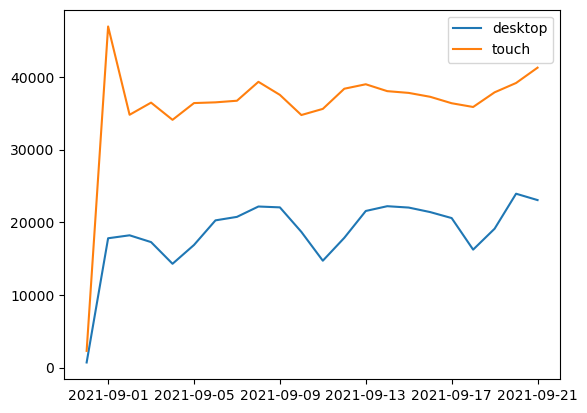

In [13]:
# 3 - графически посмотрим на динамику по дням по платформам
# динамика в целом совпадает, но в десктопе больше посадка в выходные
df_raw['date'] = df_raw['dt'].dt.date
df_grouped = df_raw.groupby(['platform', 'date'], as_index=False).agg(query_num=('query', 'count'))
for platform in list(df_grouped['platform'].drop_duplicates()):
    df_platfrom = df_grouped[df_grouped['platform'] == platform]
    plt.plot(df_platfrom['date'], df_platfrom['query_num'], label=platform)
plt.legend()

### Вопрос 1 - сравнение топ-10 запросов

In [14]:
# Генерим топ запросов для десктопа + ранг + долю от общего числа
df_platform = df_raw[df_raw['platform'] == 'desktop']
total = df_platform['query'].count()
df_desktop = df_platform.groupby(['query'], as_index=False).agg(query_num=('query', 'count'))
df_desktop['share'] = round(df_desktop['query_num']/total*100, 3)
df_desktop['rnk'] = df_desktop['query_num'].rank(ascending=False, method='dense')
df_desktop

,query,query_num,share,rnk
0,+18,11,0.003,301.0
1,+18 video,2,0.000,310.0
2,002,4,0.001,308.0
3,02 аниме,34,0.008,278.0
4,02 милый во франсе,7,0.002,305.0
...,...,...,...,...
22737,ёжик в тумане,14,0.003,298.0
22738,ёжики,107,0.026,205.0
22739,سكس,6,0.001,306.0
22740,幼女,2,0.000,310.0


In [15]:
# Генерим топ запросов для мобилки + ранг + долю от общего числа
df_platform = df_raw[df_raw['platform'] == 'touch']
total = df_platform['query'].count()
df_touch = df_platform.groupby(['query'], as_index=False).agg(query_num=('query', 'count'))
df_touch['share'] = round(df_touch['query_num']/total*100, 3)
df_touch['rnk'] = df_touch['query_num'].rank(ascending=False, method='dense')
df_touch

,query,query_num,share,rnk
0,+18,34,0.004,417.0
1,+18 video,24,0.003,427.0
2,002,15,0.002,436.0
3,02 аниме,30,0.004,421.0
4,02 милый во франсе,23,0.003,428.0
...,...,...,...,...
23846,سكس,77,0.010,374.0
23847,幼女,14,0.002,437.0
23848,视频,69,0.009,382.0
23849,보지,13,0.002,438.0


In [16]:
df_all_platforms = pd.merge(df_touch, df_desktop, how='outer', on='query', suffixes=('_touch', '_desktop'))
df_all_platforms

,query,query_num_touch,share_touch,rnk_touch,query_num_desktop,share_desktop,rnk_desktop
0,+18,34.0,0.004,417.0,11.0,0.003,301.0
1,+18 video,24.0,0.003,427.0,2.0,0.000,310.0
2,002,15.0,0.002,436.0,4.0,0.001,308.0
3,02 аниме,30.0,0.004,421.0,34.0,0.008,278.0
4,02 милый во франсе,23.0,0.003,428.0,7.0,0.002,305.0
...,...,...,...,...,...,...,...
24021,эротика бесплатно,NaN,NaN,NaN,1.0,0.000,311.0
24022,юлия пересильд фото,NaN,NaN,NaN,24.0,0.006,288.0
24023,юрий гагарин фото,NaN,NaN,NaN,22.0,0.005,290.0
24024,яндекс.диск,NaN,NaN,NaN,21.0,0.005,291.0


In [17]:
#Смотрим топ-10 на десктопе и сравниваем с их положением в mobile
df_all_platforms[df_all_platforms['rnk_desktop'] <= 10].sort_values(by='rnk_desktop', ascending=True)

,query,query_num_touch,share_touch,rnk_touch,query_num_desktop,share_desktop,rnk_desktop
8097,календарь 2021,2268.0,0.286,12.0,2810.0,0.683,1.0
20203,таблица менделеева,2278.0,0.288,11.0,2659.0,0.646,2.0
8500,картинки,1801.0,0.227,18.0,1720.0,0.418,3.0
15193,порно,10076.0,1.272,1.0,1408.0,0.342,4.0
2212,английский алфавит,1749.0,0.221,20.0,1352.0,0.329,5.0
12810,обои на рабочий стол,102.0,0.013,349.0,1143.0,0.278,6.0
12976,одноклассники (социальная сеть),5.0,0.001,446.0,1116.0,0.271,7.0
18219,секс,8262.0,1.043,2.0,947.0,0.230,8.0
2033,алфавит,1225.0,0.155,32.0,923.0,0.224,9.0
20194,таблица квадратов,587.0,0.074,82.0,883.0,0.215,10.0


In [18]:
#Смотрим топ-10 на мобильных устройствах и сравниваем с их положением в десктопе
df_all_platforms[df_all_platforms['rnk_touch'] <= 10].sort_values(by='rnk_touch', ascending=True)

,query,query_num_touch,share_touch,rnk_touch,query_num_desktop,share_desktop,rnk_desktop
15193,порно,10076.0,1.272,1.0,1408.0,0.342,4.0
18219,секс,8262.0,1.043,2.0,947.0,0.230,8.0
17492,с днём рождения женщине,4924.0,0.622,3.0,503.0,0.122,31.0
22068,хентай,4194.0,0.529,4.0,821.0,0.199,13.0
17426,с днём рождения,4123.0,0.520,5.0,297.0,0.072,79.0
17577,с днём рождения мужчине,3669.0,0.463,6.0,332.0,0.081,68.0
17276,с днем рождения,3315.0,0.418,7.0,454.0,0.110,40.0
1500,xxx,3249.0,0.410,8.0,261.0,0.063,97.0
1485,xnxx,2767.0,0.349,9.0,62.0,0.015,250.0
6123,доброе утро,2342.0,0.296,10.0,145.0,0.035,167.0


#### Отличия
На мобильных платформах сильно больше 18+ запросов и поиска картонок с поздравлениями
На десктопе вообще нет поздравлений в топе, 18+ контент менее популярный, на десктопе больше общего контента (для учебы, работы)

### Вопрос 2 - динамика во времени
Посмотрим тотал, по платформам, по запросам.
Возьму топ 5-10 запросов (смотря как будет достаточно для анализа и информативности), смотрю динамику внутри дня

In [19]:
df_raw['hour'] = df_raw['dt'].dt.hour

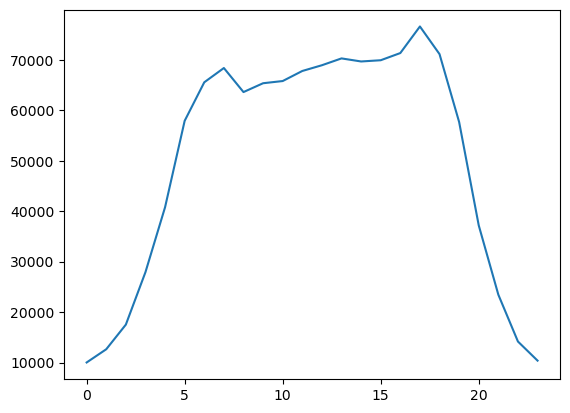

In [20]:
#Тотал
df_total = df_raw.groupby('hour', as_index=False).agg(query_cnt=('query', 'count'))
plt.plot(df_total['hour'], df_total['query_cnt'])

В целом по запросам видно, что пик приходится на время с 5 до 17 часов.
Выглядит что это время очень ранее, что такая активность в 5 утра.
Гипотезы - разные часовые пояса, что в 5 утра у восточной части России уже активное время и эти пользователи генерят запросы

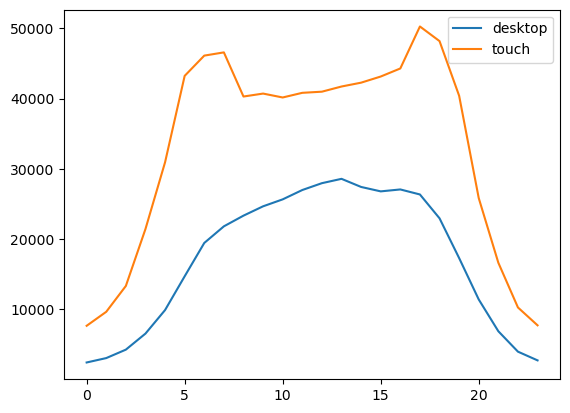

In [21]:
#Платформы
df_by_platform = df_raw.groupby(['hour', 'platform'], as_index=False).agg(query_cnt=('query', 'count'))
for platform in list(df_by_platform['platform'].drop_duplicates()):
    plt.plot(df_by_platform.loc[df_by_platform['platform'] == platform, 'hour'], 
             df_by_platform.loc[df_by_platform['platform'] == platform, 'query_cnt'],
             label=platform)
plt.legend()

На desktop достаточно ровное использование.
На touch есть два пика утром и вечером. Гипотеза - на мобильной платформе используют до и после работы.
Вообще в свете этого интересно посмотреть то же самое распределение для будних и выходных.

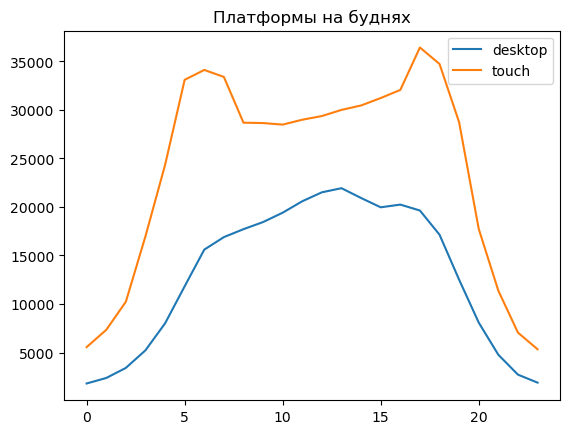

In [22]:
#Платформы для будней
df_raw['weekday'] = df_raw['dt'].dt.weekday+1 #Чтобы было с 1 до 7, так понятнее
df_by_platform = df_raw[df_raw['weekday'].between(1, 5)].groupby(['hour', 'platform'], as_index=False).agg(query_cnt=('query', 'count'))
for platform in list(df_by_platform['platform'].drop_duplicates()):
    plt.plot(df_by_platform.loc[df_by_platform['platform'] == platform, 'hour'], 
             df_by_platform.loc[df_by_platform['platform'] == platform, 'query_cnt'],
             label=platform)
plt.title('Платформы на буднях')
plt.legend()

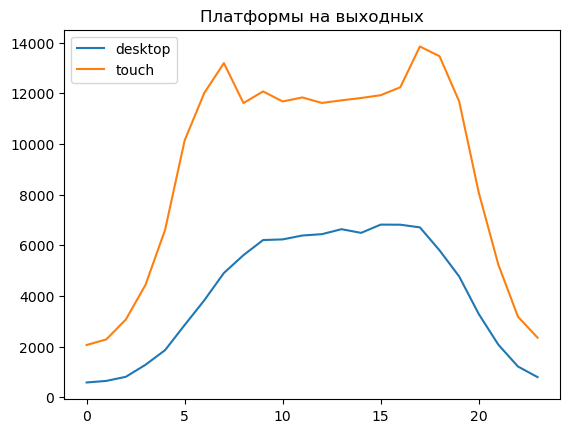

In [23]:
#Платформы для выходных
df_by_platform = df_raw[df_raw['weekday'].between(6, 7)].groupby(['hour', 'platform'], as_index=False).agg(query_cnt=('query', 'count'))
for platform in list(df_by_platform['platform'].drop_duplicates()):
    plt.plot(df_by_platform.loc[df_by_platform['platform'] == platform, 'hour'], 
             df_by_platform.loc[df_by_platform['platform'] == platform, 'query_cnt'],
             label=platform)
plt.title('Платформы на выходных')
plt.legend()

Гипотеза про связь пиков с утра и вечером и будними днями нет.
Видимо это просто поведение пользователей.

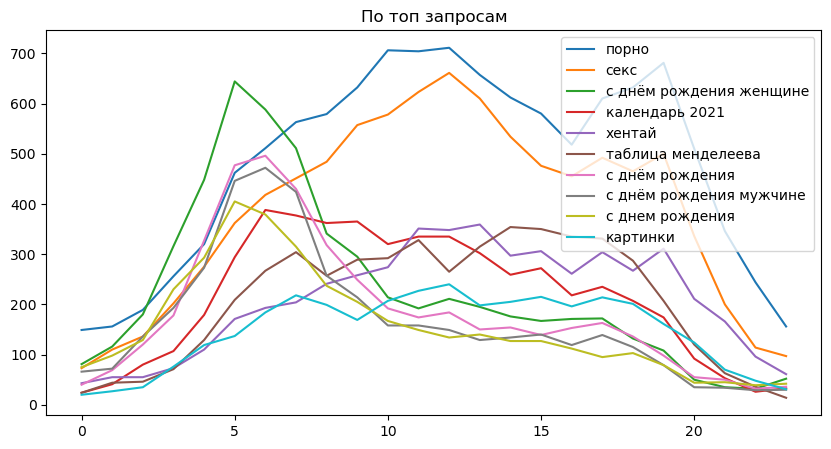

In [24]:
# Динамика по топ-10 запросов
top_query = list((
          df_raw.groupby(['query'], as_index=False)
          .agg(query_num=('query', 'count'))
          .sort_values(by='query_num', ascending=False)
          .head(10))['query'])

df_by_query = df_raw.groupby(['query', 'hour'], as_index=False).agg(query_cnt=('query', 'count'))

plt.figure(figsize=(10, 5))
for query in top_query:
    plt.plot(df_by_query.loc[df_by_query['query'] == query, 'hour'], 
             df_by_query.loc[df_by_query['query'] == query, 'query_cnt'],
             label=query)
plt.title('По топ запросам')
plt.legend()

#### Выводы
Если смотреть по запросам - то тут явно видно разное поведение пользователей в зависимости от тематики:
1. 18+ - больше запросов в вечернее время, чем у других тематик
2. Тематика поздравлений - пик с утра и в течение дня запросов меньше
3. Общие тематики - более ровный трафик в течение дня
Такое различие по тематикам отвечает и о причинах пиков ранее - утренний пик это поздравления, вечерний пик - 18+

### Вопрос 3 - топ тематик

 Для начала определяем тематику. Идея такая - разбить все запросы на "ключи" - просто входящие слова. Дальше беру частотность, смотрю глазами самые частые, пытаюсь сгруппировать в темы.
 Проще было бы по API подключиться в chatGPT и через него то же самое сделать

In [25]:
df_all_platforms['query_word_list'] = df_all_platforms['query'].str.split(' ')
df_all_platforms

,query,query_num_touch,share_touch,rnk_touch,query_num_desktop,share_desktop,rnk_desktop,query_word_list
0,+18,34.0,0.004,417.0,11.0,0.003,301.0,[+18]
1,+18 video,24.0,0.003,427.0,2.0,0.000,310.0,"[+18, video]"
2,002,15.0,0.002,436.0,4.0,0.001,308.0,[002]
3,02 аниме,30.0,0.004,421.0,34.0,0.008,278.0,"[02, аниме]"
4,02 милый во франсе,23.0,0.003,428.0,7.0,0.002,305.0,"[02, милый, во, франсе]"
...,...,...,...,...,...,...,...,...
24021,эротика бесплатно,NaN,NaN,NaN,1.0,0.000,311.0,"[эротика, бесплатно]"
24022,юлия пересильд фото,NaN,NaN,NaN,24.0,0.006,288.0,"[юлия, пересильд, фото]"
24023,юрий гагарин фото,NaN,NaN,NaN,22.0,0.005,290.0,"[юрий, гагарин, фото]"
24024,яндекс.диск,NaN,NaN,NaN,21.0,0.005,291.0,[яндекс.диск]


In [26]:
# Теперь делаем список ключей в один список, загоняем в pandas и считаем
nested = list(df_all_platforms['query_word_list'])
flatten = [[x] for word_list in nested for x in word_list]

In [27]:
# Вот этот блок прогоняю несколько раз и вручную вытаскиваю ключи для темы. Некоторые ключи оборваны чтобы учесть словоформы
df_words = pd.DataFrame(columns=['word'], data=flatten)
# Одно из самых популярных - предлоги и союзы - исключаю их, как и уже определенные тематики
# Также исключаю общие слова типа фото, картинка и тд
exclude_list = ['с', 'на', 'и', 'для', 'в', 'порно', 'секс', '18+', 'хента', 'днём', 'рождени', 'как', 'по', 'из', 
                '1', '8', 'сентября', 'марта', 'поздравлени', 'что', 'картинки', 'фото', 'это', 'красивые', 'такое', 'обои']
df_words = df_words[~df_words['word'].isin(exclude_list)]

df_words_grouped = (df_words.groupby('word', as_index=False)
                    .agg(word_cnt=('word', 'count'))
                    .sort_values(by='word_cnt', ascending=False))
df_words_grouped.head(20)

,word,word_cnt
11814,рождения,704
76,2021,414
4830,днем,275
6459,класс,233
10532,погода,200
9800,открытки,194
10639,поздравления,170
6198,карта,161
4557,день,154
5248,женщине,150


В целом бросается в глаза, что есть 2 явные тематики - 18+ и поздравления. Остальные минорные, схлопну для старта в "другое"

In [28]:
theme_dict={
        '18+':['порно', 'секс', '18+', 'хента', 'xxx', 'ххх'],
        'поздравления':['днём', 'рождени', '1 сентября', '8 марта', 'поздравлени', 'открытк']
    }

def theme_definition(query):
    theme = 'Другое'
    
    for t, words in theme_dict.items():
        if theme != 'Другое': # Уменьшаю число переборов если тема уже подобрана
            break
        else:
            for word in words:
                if word in query:
                    theme = t
                    break
    
    return theme   
    
df_raw['theme'] = df_raw['query'].apply(theme_definition)
df_raw

,query,ts,platform,dt,date,hour,weekday,theme
0,порно фото,1631786697,touch,2021-09-16 10:04:57,2021-09-16,10,4,18+
1,малевич картины,1631806465,desktop,2021-09-16 15:34:25,2021-09-16,15,4,Другое
2,секс,1631781583,touch,2021-09-16 08:39:43,2021-09-16,8,4,18+
3,с днём рождения лена,1631771563,touch,2021-09-16 05:52:43,2021-09-16,5,4,поздравления
4,зверополис порно,1631787599,touch,2021-09-16 10:19:59,2021-09-16,10,4,18+
...,...,...,...,...,...,...,...,...
1203819,бабочка,1631475653,touch,2021-09-12 19:40:53,2021-09-12,19,7,Другое
1203820,все республики россии,1631462934,touch,2021-09-12 16:08:54,2021-09-12,16,7,Другое
1203821,кухня в стиле лофт,1631432252,touch,2021-09-12 07:37:32,2021-09-12,7,7,Другое
1203822,топор,1631449347,desktop,2021-09-12 12:22:27,2021-09-12,12,7,Другое


In [29]:
#Теперь как ранее по запросам, схлопнем по устройсву и тематике и сравним
df_platform = df_raw[df_raw['platform'] == 'touch']
total = df_platform['query'].count()
df_touch = df_platform.groupby(['theme'], as_index=False).agg(query_num=('query', 'count'))
df_touch['share'] = round(df_touch['query_num']/total*100, 3)

df_platform = df_raw[df_raw['platform'] == 'desktop']
total = df_platform['query'].count()
df_desktop = df_platform.groupby(['theme'], as_index=False).agg(query_num=('query', 'count'))
df_desktop['share'] = round(df_desktop['query_num']/total*100, 3)

df_all_platforms = pd.merge(df_touch, df_desktop, how='outer', on='theme', suffixes=('_touch', '_desktop'))
df_all_platforms

,theme,query_num_touch,share_touch,query_num_desktop,share_desktop
0,18+,58168,7.342,8000,1.944
1,Другое,655296,82.712,394876,95.945
2,поздравления,78794,9.945,8690,2.111


Выделено маловато тем - в аппе на эти две категории приходится 18%, а в вебе 4%. Хотя в вебе явно разнообразнее запросы и просто вручную определять тематику не вариант.
Теперь надо выбрать, что такое контрастность. Я предлагаю измерять контрастность тематик по доле запросов из тематики относительно всех запросов. Поэтому и для проверки статзначимости используем эту же метрику. Отсюда гипотезы для проверки статзначимости:
#### H0 - доля тематики  18+/поздравления не отличается между платформами
#### H1 - в зависимости от платформы тематика различается

Поскольку мы сравниваем две категориальные переменные - тематика, по которой ищут и платформа, выборка достаточная, то можем применить критерий Хи Квадрат.

In [30]:
for t in ['18+', 'поздравления']:
    obs = [
        [df_all_platforms.loc[df_all_platforms['theme'] == t, 'query_num_touch'].sum(),
         df_all_platforms.loc[df_all_platforms['theme'] != t, 'query_num_touch'].sum()
        ],
        [df_all_platforms.loc[df_all_platforms['theme'] == t, 'query_num_desktop'].sum(),
         df_all_platforms.loc[df_all_platforms['theme'] != t, 'query_num_desktop'].sum()]
    ]
    res = chi2_contingency(obs)
    print(t, res.pvalue, 'Статзначимо' if res.pvalue < 0.05/2 else 'нет')

18+ 0.0 Статзначимо
поздравления 0.0 Статзначимо


#### Вывод
Даже с применением поправки Бонферрони (разделил допустимый alpha на 2) доля каждой из тематик статзначимо отличается 